In [2]:
!pip install -q scikit-image opencv-python-headless matplotlib tqdm transformers torch Pillow


🔹 Loading SAM 2.1 model...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/898M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/683 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

Device set to use cuda:0


🔹 Running SAM on 3 detected regions...
🔹 SSIM Similarity Score: 0.9942
🔹 Change Score: 0.47%
🔹 Total Anomalies Detected: 3


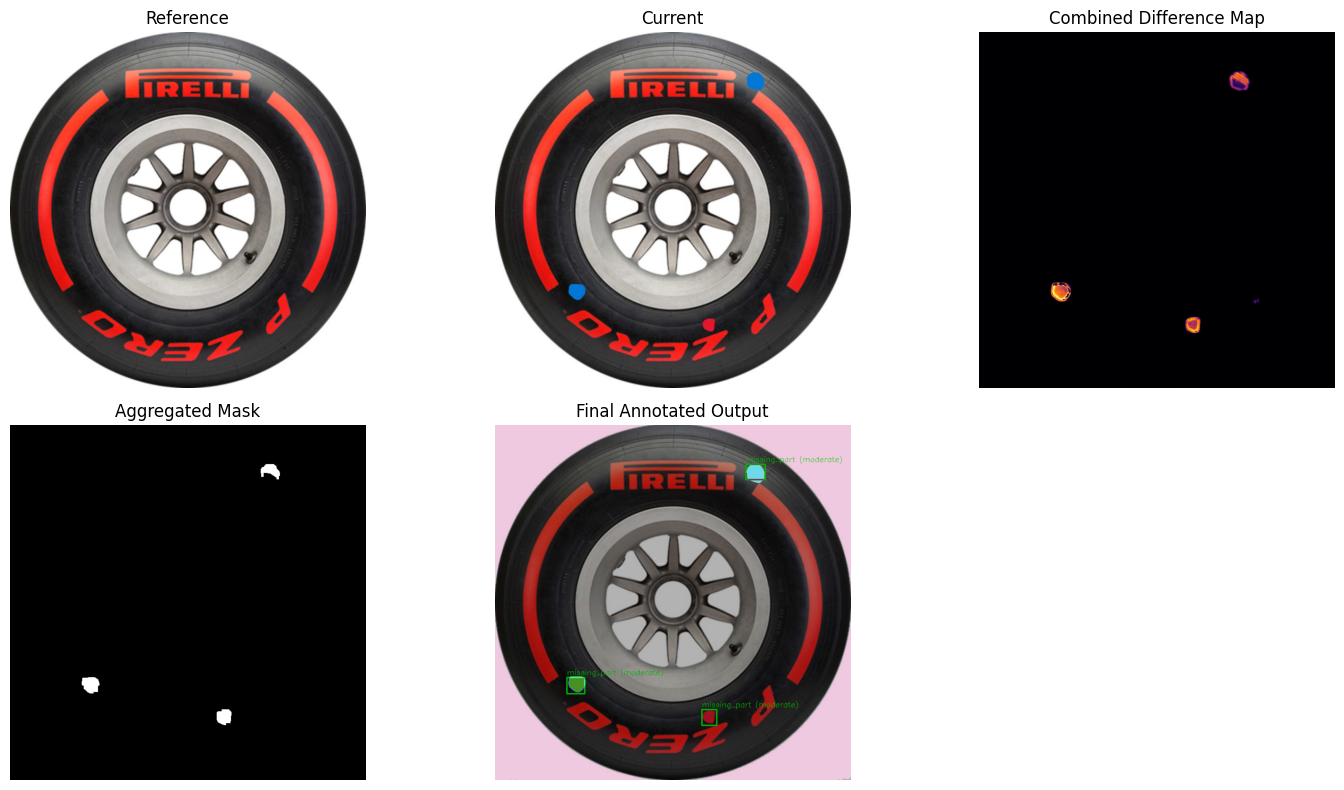


✅ Report saved as anomaly_report_sam.json


In [3]:
# ============================
# STEP 0: Setup
# ============================

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from transformers import pipeline
import torch, json
from PIL import Image

# ----------------------------
# STEP 1: Load Images
# ----------------------------
# ⚠️ MAKE SURE THESE PATHS ARE CORRECT
ref_path = "/content/race_car_tire_1.jpeg"
curr_path = "/content/race_car_tire_1_anomaly.jpeg"

ref = cv2.imread(ref_path)
curr = cv2.imread(curr_path)

if ref is None or curr is None:
    raise ValueError("⚠️ Image paths invalid. Make sure images exist!")

# Resize to same dimensions
if ref.shape != curr.shape:
    curr = cv2.resize(curr, (ref.shape[1], ref.shape[0]))

# Convert to grayscale
ref_gray = cv2.cvtColor(ref, cv2.COLOR_BGR2GRAY)
curr_gray = cv2.cvtColor(curr, cv2.COLOR_BGR2GRAY)

# ----------------------------
# STEP 2: Difference Computation
# ----------------------------
score, diff_ssim = ssim(ref_gray, curr_gray, full=True)
diff_ssim = (1 - diff_ssim) * 255
diff_ssim = diff_ssim.astype("uint8")

diff_abs = cv2.absdiff(ref_gray, curr_gray)
combined_diff = cv2.addWeighted(diff_abs, 0.5, diff_ssim, 0.5, 0)

# ----------------------------
# STEP 3: Global Thresholding & Cleanup (CORRECTED)
# ----------------------------
# Use a simple global threshold. 50 is a good starting point for a diff map.
# This creates a binary mask: 255 (white) for pixels > 50, 0 (black) for pixels <= 50.
# This correctly isolates the bright anomaly spots.
_, thresh = cv2.threshold(combined_diff, 50, 255, cv2.THRESH_BINARY)

# Standard morphological cleanup to remove small noise
kernel = np.ones((3, 3), np.uint8)
thresh_clean = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
thresh_clean = cv2.morphologyEx(thresh_clean, cv2.MORPH_CLOSE, kernel, iterations=3)

# This is our final, correct mask
agg_mask = thresh_clean

# ----------------------------
# STEP 4: Contours & Preliminary Anomalies
# ----------------------------
contours, _ = cv2.findContours(agg_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
anomalies = []
annotated = curr.copy()

for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    area = w * h
    if area < 100:  # Filter out very small noise
        continue

    # Severity
    if area > 2000:
        severity = "major"
    elif area > 500:
        severity = "moderate"
    else:
        severity = "minor"

    # Type heuristic
    aspect_ratio = w / h
    if aspect_ratio > 3:
        defect_type = "scratch"
    elif aspect_ratio < 0.5:
        defect_type = "spot"
    else:
        defect_type = "missing_part"

    anomalies.append({
        "x": int(x), "y": int(y), "w": int(w), "h": int(h),
        "type": defect_type, "severity": severity
    })

# ----------------------------
# STEP 5: SAM 2 Segmentation (with Box Prompts) (CORRECTED)
# ----------------------------
print("🔹 Loading SAM 2.1 model...")
sam_generator = pipeline(
    "mask-generation",
    model="facebook/sam2.1-hiera-large",
    device=0 if torch.cuda.is_available() else -1
)

# Prepare bounding boxes for SAM
# SAM expects boxes in [xmin, ymin, xmax, ymax] format
input_boxes = []
for a in anomalies:
    x, y, w, h = a["x"], a["y"], a["w"], a["h"]
    input_boxes.append([x, y, x + w, y + h])

# Convert the full 'current' image to PIL format
curr_pil = Image.fromarray(cv2.cvtColor(curr, cv2.COLOR_BGR2RGB))

print(f"🔹 Running SAM on {len(input_boxes)} detected regions...")
# Run SAM ONCE on the full image, passing all boxes as prompts
outputs = sam_generator(curr_pil, input_boxes=input_boxes, points_per_batch=32)

overlay = np.zeros_like(curr, dtype=np.float32)
annotated_final = annotated.copy() # Use the copy from Step 4

# Check if outputs contain the 'masks' key as expected
if "masks" not in outputs:
    print("⚠️ SAM output does not contain 'masks'. Skipping overlay.")
else:
    # Iterate over the anomalies and the masks returned by SAM
    # The outputs['masks'] list will correspond to the input_boxes list
    for a, mask_tensor in zip(anomalies, outputs["masks"]):
        x, y, w, h = a["x"], a["y"], a["w"], a["h"]

        # Convert mask tensor to numpy array
        # The mask returned by SAM is for the *full image*
        mask = mask_tensor.cpu().numpy().squeeze()
        mask = (mask > 0.5).astype(np.float32) # Boolean to float

        # Generate a random color for this anomaly
        color = np.random.rand(3)

        # Apply the color only where the mask is active
        for i in range(3):
            # Use the full-image mask to update the overlay
            overlay[:, :, i] += mask * color[i]

        # Draw bounding boxes and labels on the original 'annotated' image
        cv2.rectangle(annotated_final, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(annotated_final, f"{a['type']} ({a['severity']})", (x, y - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

# Normalize overlay and blend with the annotated image
overlay = np.clip(overlay, 0, 1)
# Create a copy to avoid type errors during blending
annotated_float = annotated_final.astype(np.float32) / 255.0
annotated_blended = cv2.addWeighted(annotated_float, 0.7, overlay, 0.6, 0)
annotated_blended = (annotated_blended * 255).astype(np.uint8)

# --- IMPORTANT: Update the plot variable ---
# Your visualization step (Step 7) plots a variable named 'annotated'
# We must assign our final result back to that variable.
annotated = annotated_blended

# ----------------------------
# STEP 6: Change Score & Visualization
# ----------------------------
total_pixels = ref_gray.size
change_pixels = np.count_nonzero(agg_mask)
change_score = (change_pixels / total_pixels) * 100

print(f"🔹 SSIM Similarity Score: {score:.4f}")
print(f"🔹 Change Score: {change_score:.2f}%")
print(f"🔹 Total Anomalies Detected: {len(anomalies)}")

# ----------------------------
# STEP 7: Visualization
# ----------------------------
plt.figure(figsize=(15, 8))
plt.subplot(2, 3, 1); plt.title("Reference"); plt.imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB)); plt.axis('off')
plt.subplot(2, 3, 2); plt.title("Current"); plt.imshow(cv2.cvtColor(curr, cv2.COLOR_BGR2RGB)); plt.axis('off')
plt.subplot(2, 3, 3); plt.title("Combined Difference Map"); plt.imshow(combined_diff, cmap='inferno'); plt.axis('off')
plt.subplot(2, 3, 4); plt.title("Aggregated Mask"); plt.imshow(agg_mask, cmap='gray'); plt.axis('off')
plt.subplot(2, 3, 5); plt.title("Final Annotated Output"); plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)); plt.axis('off')
plt.tight_layout(); plt.show()

# ----------------------------
# STEP 8: JSON Report
# ----------------------------
report = {
    "image_name": curr_path,
    "ssim_score": float(score),
    "change_score_percent": float(change_score),
    "anomalies": anomalies
}

with open("anomaly_report_sam.json", "w") as f:
    json.dump(report, f, indent=4)

print("\n✅ Report saved as anomaly_report_sam.json")